# Predicting Movie Rates with Decision Tree

In this report, we are building step by step a decision tree to predict user ratings on movies using the MovieLens dataset, available at http://grouplens.org/datasets/movielens/

The dataset is composed by 3 main files:

**movies.dat:** this file contains information of all movies, in the format < movie id > :: < movie name > :: < pipe separeted list of genders >

**users.dat:** this file contains information of all users, in the format < user id > :: < user gender > :: < user age > :: < ocupation > :: < zip code > 

**ratings.dat:** this file contains information of all ratings, in the format < user id > :: < movie id > :: < rating > :: < timestamp >


For the purpose of this project, **20 ratings were added** to the dataset, based on the personal ratings of the authors of this paper. They correspond to all ratings from users with id 6041 and 6042. 

## Pre-processing data

### Building data frame

The first step in this project is to join the data in the 3 data files into a feature and a label matrices. It is very important to carefully choose the attributes to build and train the tree.

The function **build_features** does all the processing, and returns the dataframe we will be using. The function **get_genre_id** takes a list of genres and returns its corresponding id.

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np

def get_genre_id(genres_list):
    """
    return the integer id of a list of genres, 
    which is the integer corresponding to the binary intersection of the list with all the genres
    """
    # movie genres
    genres = [
        'Action',
        'Adventure',
        'Animation',
        'Children\'s',
        'Comedy',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western'
    ]
    # creating id
    id = 0
    weight = 1
    for genre in genres:
        if genre in genres_list:
            id += weight
        weight*=2
    return str(id)
    

def build_features(columns=None):
    """
    read data from movies, users and rating and return a single pandas dataframe
    of the joined tables, containing all info on ratings.
    If columns is passed, only those columns are selected.
    """
    print "Building features. This may take a while..."
    # reading movies data
    movies_df = pd.DataFrame(columns=['movie_id', 'genre'])
    with open('../data/movies.dat','r') as file:
        lines = file.readlines()
        for idx in range(len(lines)):
            row = lines[idx].split("::")
            movie_genres = row[-1][:-1].split('|')
            row = row[:-2] # ignore genre and movie name
            row.append(get_genre_id(movie_genres)) # append genre id
            movies_df.loc[idx] = row
    
    # reading users data
    users_df = pd.read_table('../data/users.dat', 
                    names=['user_id', 'gender', 'age', 'ocupation', 'zip_code'], 
                     sep='::', engine='python')
    users_df['user_id'] = users_df['user_id'].apply(lambda x: str(x))
    users_df['ocupation'] = users_df['ocupation'].apply(lambda x: str(x))
    
    # reading ratings data
    ratings_df = pd.read_table('../data/ratings.dat', 
                    names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                    sep='::', engine='python')
    ratings_df['movie_id'] = ratings_df['movie_id'].apply(lambda x: str(x))
    ratings_df['user_id'] = ratings_df['user_id'].apply(lambda x: str(x))
    
    # join tables
    user_ratings_df = ratings_df.merge(users_df, how='inner', on='user_id')
    features_df = user_ratings_df.merge(movies_df, how='inner', on='movie_id')
    
    # drop unwanted features
    if columns is not None:
        features_df = features_df[columns]

    # print first 5 rows
    print "Done. Showing 5 first rows:"
    display(features_df.head()) 
    
    return features_df
    
data = build_features()

Building features. This may take a while...
Done. Showing 5 first rows:


,user_id,movie_id,rating,timestamp,gender,age,ocupation,zip_code,genre
0,1,1193,5,978300760,F,1,10,48067,64
1,2,1193,5,978298413,M,56,16,70072,64
2,12,1193,4,978220179,M,25,12,32793,64
3,15,1193,4,978199279,M,25,7,22903,64
4,17,1193,5,978158471,M,50,1,95350,64


### Choosing features

To better understand our data, let's take a look at the number of distinct values for each feature.

In [2]:
for feature in data.columns:
    print "Number of distinct values of field " + feature + ":",
    print str(len(data[feature].unique()))

Number of distinct values of field user_id: 6041
Number of distinct values of field movie_id: 3706
Number of distinct values of field rating: 5
Number of distinct values of field timestamp: 458455
Number of distinct values of field gender: 2
Number of distinct values of field age: 7
Number of distinct values of field ocupation: 21
Number of distinct values of field zip_code: 3440
Number of distinct values of field genre: 263


In our first approach, we will try to predict the rating without using explicitely the id of the movie and the id of the user. This is because, although they could be good criteria, the large amount of different values in those columns represent a great computational cost. The same goes to the user's zip code and timestamps. For those features, it is unlikely that they wield much relevant information. Finally, we will be using the genres of the movies. There are 17 genres (Action, Adventure, Animation, Children, Comedy, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War and Western). We will store all that information in a single number, build with the binary representation of the movies genres. Since there are 17 different genres, we will be storing numbers from 0 to 2^17-1 = 131071. In practice, we expect a lot less different genre values (in fact, we get only 263 different values). Note that should give as a decision tree with about 2 \* 7 \* 21 \* 263 = 77322, which seems reasonable. We will now proceed to create the tree.

### Train/Validation/Test split

We now construct a function to split our dataset into three different sets:

- A training set, which will be used to build the classifiers
- A validation set, which will be used to determine the best hyperparameters of the classifiers (for example, the maximum depth of the three)
- A test set, which will be used to measure the performance

We will randomly construct the sets, and we will spit the sets with 60%, 20% and 20% of the shuffled data, respectively for the trainig, validation and test sets. Since decision trees are very prone to overfit, it is very important we get **stratified samples** from the population. The function **dataset_split** takes care of that, keeping the ratio between classes approximately the same. 

In [3]:
def dataset_split(df, label_name, train_size=0.6, validation_size=0.2):
    """
    splits the data into training, validation and test sets
    """
    
    # empty dataframes
    train_set = pd.DataFrame(columns=list(df.columns))
    validation_set = pd.DataFrame(columns=list(df.columns))
    test_set = pd.DataFrame(columns=list(df.columns))
    
    # stratify sampling
    labels = df[label_name].unique()
    for label in labels:
        label_df = df.ix[df[label_name] == label]
        label_df = label_df.sample(frac=1) #randomize
        size = len(label_df.index)
        validation_start = int(train_size*size)
        test_start = int((train_size+validation_size)*size)
        train_set = pd.concat([train_set, label_df[:validation_start]])
        validation_set = pd.concat([validation_set, label_df[validation_start:test_start]])
        test_set = pd.concat([test_set, label_df[test_start:]])
    
    # randomizing
    train_set = train_set.sample(frac=1)
    validation_set = validation_set.sample(frac=1)
    test_set = test_set.sample(frac=1)
    
    return train_set, validation_set, test_set

train_set, validation_set, test_set = dataset_split(data,'rating')

print "Training set size: " + str(len(train_set.index))
print "Validation set size: " + str(len(validation_set.index))
print "Test set size: " + str(len(test_set.index))

Training set size: 600136
Validation set size: 200046
Test set size: 200047


## Building the Tree


### Entropy

We need to create a method for evaluating the homogenity of the set. We will use the standard entropy function for that. 

For that, it will be usefull to have a function that, given a dataframe, count how many rows are there of each label. Let's construct that.

In [4]:
def label_counts(df, label_name):
    """
    returns the count of each label value
    """
    return df[label_name].value_counts()
    
print "Printing how many ratings are for each number of stars:"
counts = label_counts(data, 'rating')
for rating, count in counts.iteritems():
    print "Number of ", rating, "starts ratings:", str(count)

Printing how many ratings are for each number of stars:
Number of  4 starts ratings: 348984
Number of  3 starts ratings: 261199
Number of  5 starts ratings: 226315
Number of  2 starts ratings: 107557
Number of  1 starts ratings: 56174


Moving on to our entropy function:

In [5]:
from math import log 
log2 = lambda x: log(x)/log(2)

def entropy(df, label_name):
    """
    returns the entropy in a dataset
    """
    s = 0.0
    if len(df.index) == 0:
        return s
    
    counts = label_counts(df, label_name)
    size = len(df.index)
    for _, count in counts.iteritems():
        p = float(count)/size
        s -= p*log2(p)
    return s

print "Initial entropy is:", entropy(data, 'rating')

Initial entropy is: 2.10022390379


### Splitting the dataset

Another usefull method for building our decision tree classifiers is one that, given some data rows, a feature and a list of values, splits the data into disjoint subsets, according to the value. We will build that now.

In [6]:
def split_df(df, feature, values):
    """
    splits a data frame into separate subsets, one for each value
    each one corresponding to all the data which has df[feature] == value
    """
    subsets = {}
    for value in values:
        local_df = df.ix[df[feature] == value]
        subsets[value] = local_df
        
    return subsets

### Defining a rule of thumb for preditions

Here we define a rule to best predict the outcome of a dataset, if no other information is provided. Here we use the average of all the labels in the dataset, since that minimizes the squared error on the dataset.

In [7]:
def get_prediction(counts):
    """
    returns the prediction given the count of each label value
    """
    if len(counts) == 0:
        # return random number
        return np.random.randint(5)+1
    pred = 0.0
    total = 0.0
    for rating, count in counts.iteritems():
        pred += count*rating
        total += count
    return int(pred/total + 0.5)

### Building the tree

Now we start creating the tree. We use a recursive approach, building a node which maximizes the information gain at each step. Note that a node is represented by 3 attributes: the name of the feature, a list of the number of ratings for each class and a dictionary of the children nodes, where the keys are the values assumed by the feature. These variables are passed as parameters to the split_df method above written, dividing the dataset into disjoint subsets.

In [8]:
class node:
    """
    Tree node
    """
    def __init__(self, feature, counts, children={}):
        self.feature = feature
        self.children = children
        self.counts = counts

In [18]:
class TreeClassifier():
    """
    Decision Tree classifier
    """
    def __init__(self):
        self.tree = None
        
    def find_best_criteria(self, df, label_name):
        """
        build a node with a feature and a value 
        that maximizes information gain for the given dataframe
        """
        # initial variables
        best_criteria = None
        best_gain = 0.0
        best_sets = {}
        current_entropy = entropy(df, label_name)

        # iterate through all possible choices and select the one with the biggest information gain
        for feature in df.columns.values:
            if feature != label_name:
                # select different values
                values = df[feature].unique()
                # split data
                subsets = split_df(df, feature, values)
                # calculate entropy gain
                gain = current_entropy
                for value, subset in subsets.iteritems():
                    p = float(len(subset.index))/len(df.index)
                    gain -= p*entropy(subset, label_name)
                # update if necessary
                if gain > best_gain:
                    best_gain = gain
                    best_criteria = feature
                    best_sets = subsets
        return best_criteria, best_sets

    def build_tree(self, df, label_name, max_depth=None):
        """
        build the decision tree
        """
        if len(df.index) == 0 or max_depth == 0:
            return None
        feature, subsets = self.find_best_criteria(df, label_name)
        if feature is None:
            return None
        new_depth = None if max_depth is None else max_depth-1

        children = {}
        for value, subset in subsets.iteritems():
            children[value] = self.build_tree(subset, label_name, new_depth)
        return node(feature, label_counts(df, label_name), children)
    
    def train(self, df, label_name, max_depth=None):
        """
        trains classifier with a given dataset
        """
        self.tree = self.build_tree(df, label_name, max_depth)
        
    def predict(self, tree, row):
        """
        predict the result of a given a data row
        """
        if tree is None:
            raise Exception("This model was not trained yet. Please train the decision tree before calling the predict method.")
        if (not tree.children or 
                row[tree.feature] not in tree.children or 
                tree.children[row[tree.feature]] is None):
            return get_prediction(tree.counts)

        return self.predict(tree.children[row[tree.feature]], row)
    
    def score(self, df, labels, label_name):
        """
        returns the confusion matrix for the classifier in a given test set
        """
        if self.tree is None:
            raise Exception("This model was not trained yet. Please train the decision tree before calling the predict method.")
        # creating the confusion matrix
        confusion_matrix = {}
        for label in labels:
            label_dict = {}
            for other_label in labels:
                label_dict[other_label] = 0
            confusion_matrix[label] = label_dict

        for _, row in df.iterrows():
            prediction = self.predict(self.tree, row)
            confusion_matrix[prediction][row[label_name]] += 1

        return confusion_matrix

### Testing our tree

Let's build a simple tree with maximum depth 2 to make sure everything is ok.

In [10]:
print "Building tree. This may take a while..."
columns = ['age', 'genre', 'gender', 'ocupation', 'rating']
decision_tree_clf = TreeClassifier()
decision_tree_clf.train(train_set[columns], 'rating', 2)
print "Tree built. Predicting ratings for all movies seen by users 6041 and 6042..."
rows = data.ix[data['user_id'].isin(['6041','6042'])]
for _, row in rows.iterrows():
    prediction = decision_tree_clf.predict(decision_tree_clf.tree, row)
    print "Tree prediction for user", row['user_id'], "and movie", row['movie_id'] + ":", str(prediction) 


Building tree. This may take a while...
Tree built. Predicting ratings for all movies seen by users 6041 and 6042...
Tree prediction for user 6041 and movie 527: 4
Tree prediction for user 6041 and movie 260: 4
Tree prediction for user 6041 and movie 608: 4
Tree prediction for user 6041 and movie 1246: 4
Tree prediction for user 6041 and movie 1225: 4
Tree prediction for user 6041 and movie 318: 4
Tree prediction for user 6041 and movie 215: 4
Tree prediction for user 6041 and movie 47: 4
Tree prediction for user 6041 and movie 296: 4
Tree prediction for user 6041 and movie 50: 4
Tree prediction for user 6041 and movie 1732: 4
Tree prediction for user 6041 and movie 73: 4
Tree prediction for user 6041 and movie 924: 4
Tree prediction for user 6041 and movie 1203: 4
Tree prediction for user 6041 and movie 3503: 4
Tree prediction for user 6041 and movie 1206: 4
Tree prediction for user 6041 and movie 771: 4
Tree prediction for user 6041 and movie 1222: 4
Tree prediction for user 6041 and

## Measuring performance

Lets build some usefull functions to better measure the performance of a classifier. First of all, 
we'll build a function to plot the confusion matrix in a more user friendly display let's test this with the confusion matrix from the classifier we built above, for the test set.



Predicting ratings for test set. This may take a while...
Done. Plotting the confusion matrix


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


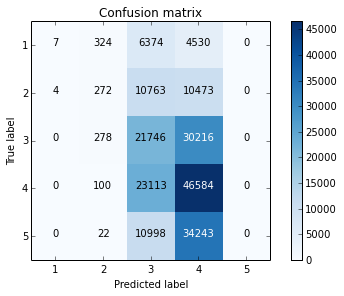

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(matrix_in, classes, cmap=plt.cm.Blues):
    classes.sort()
    matrix = []
    for s_class in classes:
        row = []
        for o_class in classes:
            row.append(matrix_in[o_class][s_class])
        matrix.append(row)
    cm = np.array(matrix, dtype=int)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks,classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
labels = data['rating'].unique()
print "Predicting ratings for test set. This may take a while..."
confusion_matrix = decision_tree_clf.score(test_set[columns], labels, 'rating')
print "Done. Plotting the confusion matrix"
plot_confusion_matrix(confusion_matrix, labels)
    

### Calculating scores

We will now build a function that, given a confusion matrix, computes the accuracy, mean square error and Kappa score.

In [13]:
def get_statistics(confusion_matrix, labels): 
    """
    compute accuracy, mean square error and kappa 
    """
    total = 0.0
    rights = 0.0
    error = 0.0
    true_totals = np.zeros(len(labels)+1)
    predict_totals = np.zeros(len(labels)+1)
    for true_label in labels:
        for predicted_label in labels:
            current_val = confusion_matrix[predicted_label][true_label]
            total += current_val
            error += abs(true_label-predicted_label)**2 * current_val
            predict_totals[int(predicted_label)] += current_val
            true_totals[int(true_label)] += current_val
        rights += confusion_matrix[true_label][true_label]
    accuracy = rights/total
    error /= total
    
    ef = 0.0
    for label in labels:
        ef += true_totals[int(label)]*predict_totals[int(label)]/total
    K = (rights-ef)/(total-ef)
    return accuracy, error, K

accuracy, error, kappa = get_statistics(confusion_matrix, labels)
print "Accuracy:", accuracy
print "Mean Square Error:", error
print "Kappa score:", kappa 

Accuracy: 0.342964403365
Mean Square Error: 1.25814933491
Kappa score: 0.0398970046222


## Finding the best classifier

Using the validation set, we will now find the best depth for the tree. We should expect large trees to overfit and small trees to underfit. Let's see how the means square error changes with the maximum depth of the tree and use that to get the best classifier.

Finding best depth. This may take a while...
Training classifier with depth 2...
Mean quadratic error for depth = 2: 1.25858552533
Best tree depth: 2
Accuracy on test set: 0.342964403365
Mean quadratic error on test set: 1.25814933491
Kappa score on test set: 0.0398970046222
Plotting confusion matrix


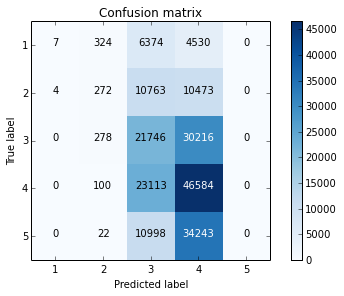

In [19]:
def find_best_depth(train_set, validation_set, depths, columns=None):
    """
    finds the depth that scores the most in the validation set, 
    using least mean quadratic error as criteria
    """
    print "Finding best depth. This may take a while..."
    best_depth = None
    best_clf = None
    minimum_error =  float('inf')
    if columns is not None:
        train_set = train_set[columns]
        validation_set = validation_set[columns]
    for depth in depths:
        print "Training classifier with depth " + str(depth) + "..."
        clf = TreeClassifier()
        clf.train(train_set, 'rating', depth)
        confusion_matrix = clf.score(validation_set, labels, 'rating')
        _, error, _ = get_statistics(confusion_matrix, labels)
        print "Mean quadratic error for depth = " + str(depth) + ": " + str(error)
        if error < minimum_error:
            minimum_error = error
            best_depth = depth
            best_clf = clf
    return best_depth, best_clf

best_depth, best_clf = find_best_depth(train_set, validation_set, [2], columns)

confusion_matrix = best_clf.score(test_set[columns], labels, 'rating')
accuracy, error, kappa = get_statistics(confusion_matrix, labels)

print "======================================"
print "Best tree depth:", best_depth
print "Accuracy on test set: " + str(accuracy)
print "Mean quadratic error on test set: " + str(error)
print "Kappa score on test set: " + str(kappa)
print "Plotting confusion matrix"
plot_confusion_matrix(confusion_matrix, labels)

## A second approach

While this first approach worked, the scores show there is still room for improvement. We now propose to use, instead of the movie genres, their id. In this approach, we can drop the genre features, which will save us some computational cost, in exchange for the id feature, which will be more computationally expensive. For each tree, we will be using only the features: **user gender**, **user age**, **user ocupation** and **movie_id**. Since there are 3952 different movies (as opposed to the 263 gender combinations we previously used), we should expect larger trees and higher computational costs for both creating the tree and predicting. 

Lets build this second approach and see how it scores.


Finding best depth. This may take a while...
Training classifier with depth 2...
Mean quadratic error for depth = 2: 1.03884106655
Best tree depth: 2
Accuracy on test set: 0.379315860773
Mean quadratic error on test set: 1.03858093348
Kappa score on test set: 0.103929617423
Plotting confusion matrix


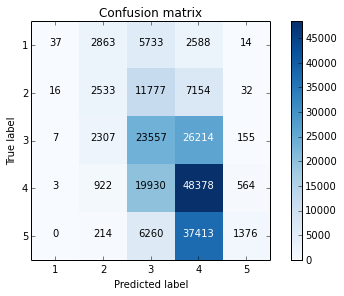

In [20]:
columns2 = ['age', 'gender', 'ocupation', 'movie_id', 'rating']
best_depth2, best_clf2 = find_best_depth(train_set, validation_set, [2], columns2)

confusion_matrix2 = best_clf2.score(test_set[columns2], labels, 'rating')
accuracy2, error2, kappa2 = get_statistics(confusion_matrix2, labels)

print "======================================"
print "Best tree depth:", best_depth2
print "Accuracy on test set: " + str(accuracy2)
print "Mean quadratic error on test set: " + str(error2)
print "Kappa score on test set: " + str(kappa2)
print "Plotting confusion matrix"
plot_confusion_matrix(confusion_matrix2, labels)

### Movie Average Classifier

Finally, we compare the built decision tree classifiers with the Movie Average Classifier, which predicts, for every movie, the mean of all ratings for that movie. Let's see how this classifier scores on our dataset.

Calculating score. This may take a while...
Done. Plotting confusion matrix.
Accuracy on test set: 0.394234566276
Mean quadratic error on test set: 1.00908253258
Kappa score on test set: 0.0967592031959


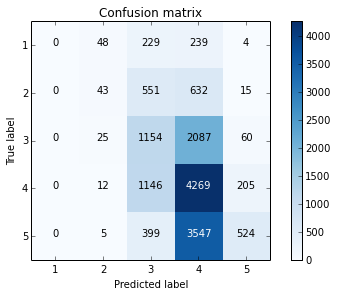

In [21]:
def movie_avg_train_and_predict(train_set, test_set, data, columns):
    movies = test_set['movie_id'].unique()
    _test_set = test_set[columns]
    _train_set = train_set[columns]
    _data = data[columns]
    
    movie_avg_cm = {}
    for label in labels:
        label_dict = {}
        for other_label in labels:
            label_dict[other_label] = 0
        movie_avg_cm[label] = label_dict

    i = 0
    for movie in movies:
        if i > 100:
            break
        i += 1
        if i % 200 == 0:
            print "Calculated score for", str(i), "of", str(len(movies)), "movies."
        counts = label_counts(_test_set.ix[data['movie_id'] == movie], 'rating')
        train_counts = label_counts(_train_set.ix[_data['movie_id'] == movie], 'rating')
        prediction = get_prediction(train_counts)
        for true_label, count in counts.iteritems():
            movie_avg_cm[prediction][true_label] += count
    return movie_avg_cm

print "Calculating score. This may take a while..."
columns_movie_avg = ['movie_id', 'rating']
movie_avg_cm = movie_avg_train_and_predict(train_set, test_set, data, columns_movie_avg)
print "Done. Plotting confusion matrix."
plot_confusion_matrix(movie_avg_cm, labels)
(movie_avg_accuracy, movie_avg_error, movie_avg_kappa) = get_statistics(movie_avg_cm, labels)
print "======================================"
print "Accuracy on test set: " + str(movie_avg_accuracy)
print "Mean quadratic error on test set: " + str(movie_avg_error)
print "Kappa score on test set: " + str(movie_avg_kappa)

### Final comparissons

Finally, we compare scores for all the approaches.

{1: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 2: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 3: {1: 0, 2: 0, 3: 1, 4: 0, 5: 0}, 4: {1: 0, 2: 0, 3: 1, 4: 13, 5: 5}, 5: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}}


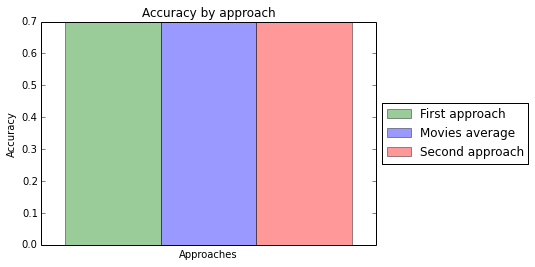

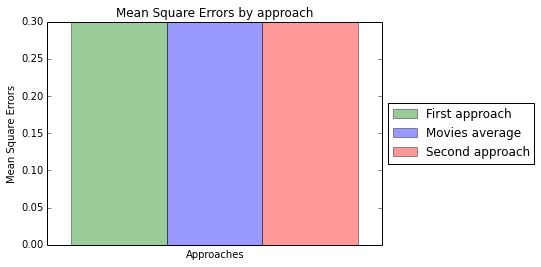

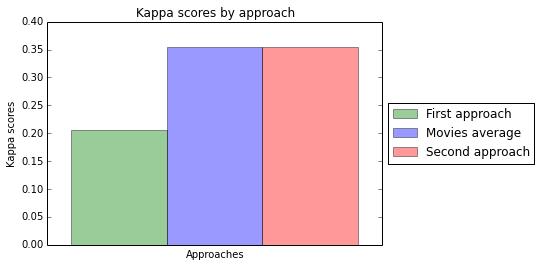

In [22]:
movie_avg_columns = ['movie_id', 'rating']
columns = ['age', 'genre', 'gender', 'ocupation', 'rating']
columns2 = ['age', 'gender', 'ocupation', 'movie_id', 'rating']
test_set_personal = data.ix[data['user_id'].isin(['6041','6042'])]

confusion_matrix = best_clf.score(test_set_personal[columns], labels, 'rating')
confusion_matrix2 = best_clf2.score(test_set_personal[columns2], labels, 'rating')
movie_avg_cm = movie_avg_train_and_predict(train_set, test_set_personal, data, movie_avg_columns)

print confusion_matrix

(accuracy, error, kappa) = get_statistics(confusion_matrix, labels)
(accuracy2, error2, kappa2) = get_statistics(confusion_matrix2, labels)
(movie_avg_accuracy, movie_avg_error, movie_avg_kappa) = get_statistics(movie_avg_cm, labels)

accuracies = [accuracy, movie_avg_accuracy, accuracy2]
errors = [error, movie_avg_error, error2]
kappas = [kappa, movie_avg_kappa, kappa2]
names = ['First approach', 'Movies average', 'Second approach']
colors = ['g','b','r']

def plot_statistic (statistic, names, colors, statistic_name):
    """
    plot statistics
    """
    fig, ax = plt.subplots()
    bar_width = 0.1
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    for index in range(len(statistic)):
        rect = plt.bar(0.075+bar_width*index, statistic[index], bar_width,
                      alpha=opacity,
                      color=colors[index],
                      error_kw=error_config,
                      label=names[index])
    plt.xlabel('Approaches')
    plt.ylabel(statistic_name)
    plt.title(statistic_name + " by approach")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(axis='x', which='both',bottom='off', top='off', labelbottom='off')
    plt.show()
    
plot_statistic(accuracies, names, colors, 'Accuracy')
plot_statistic(errors, names, colors, 'Mean Square Errors')
plot_statistic(kappas, names, colors, 'Kappa scores')

Lastly and just for fun, we compare the confusion matrix and scores for the 3 classifiers, using data from the movies rated by the authors.

In [ ]:

kappas = [kappa, movie_avg_kappa, kappa2]
names = ['First approach', 'Movies average', 'Second approach']
colors = ['g','b','r']

plot_statistic(accuracies, names, colors, 'Accuracy')
plot_statistic(errors, names, colors, 'Mean Square Errors')
plot_statistic(kappas, names, colors, 'Kappa scores')